# Week 5 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. This week, we ask you to articulate what your sample represents in context of your final project, and draw upon methods we have developed over the last three weeks to draw reasonable and representative samples. 

This week we also pivot from our recent work on unsupervized machine learning approaches to explore how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in the two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [9]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3
import nltk

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

## ***What?*** 


I plan to investigate and compare samples from two corpora related to the literature on early linguistic development. First, I will work with a corpus of the text from 100 popular children's picture books sourced from [Montag et al., 2015](http://journals.sagepub.com/doi/abs/10.1177/0956797615594361). Also, I will work on recorded transcipt corpora from the [Language Development Project](https://ldp.uchicago.edu/) based at UChicago; this project has collected a huge database of recorded and transcribed conversations between caregivers and their children at various stages of development, providing a wealth of information about the content of child-produced and child-directed speech throughout linguistic development. Through this project I hope to use these two corpora to examine substantive differences in syntactical content, potentially illuminating the important role played by books on early language learning.

## ***Why?***

While, within the developmental literature, much has been studied about the content of child-direct and -exposed speech, less work has focused on the content of children's books, with even less directly comparing the two kinds of linguistic input. This kind of analysis is notably absent in the wake of widely-publicized projects concerning the impact of language exposure (through conversation & written text) on developmental outcomes (e.g., [TMW Initiative](http://thirtymillionwords.org/tmw-initiative/)). Through my project, I would contribute to discussions surrounding the influence of children's literature on linguistic development by comparing the relative content/contributions of child-directed speech and popular children's picture books.

## ***How?***

At this stage, most of what I am interested in pertains to corpus linguistics in each sample set. For example, I am interested in replicating some work (e.g., [Montag et al., 2015](http://journals.sagepub.com/doi/abs/10.1177/0956797615594361), [Montag et al, 2017](https://psyarxiv.com/4p8r2/)) examining word type and token statistics between similarly-sized books and child-directed speech samples. I'd like to investigate more in this vein; I am curious to examine whether certain parts of speech or syntactical components appear more or less often in one corpus compared to another. Relative discrepancies would indicate particular roles played by each kind of input in contributing to lingustic development, pointing towards a mechanism by which development might be assessed / improved among at-risk populations. 

In order to conduct this kind of investigation, I aim to make heavy use of stemming and lemmatizing procedures as covered in Week 2 of the course. This will be particularly useful in my investigation of word type and token statistics. Since I am interested in potential discrepancies in parts-of-speech as well, I will want to make heavy use of the POS tagging and parsing techiques to be covered in Week 7. I haven't had much luck with clustering/topic modeling/word embedding models in previous weeks' assignments, but potentially, with some fine tuning, they could reveal some insights about how samples from the two corpora differ in ways more abstract than the word level. Finally, if I do find there to be substantive differences between the content in the two corpora, it could be enlightening/fun to train a classifier to categorize extracts based on POS, word types, etc.

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

## ***Which (words)?***

As previously mentioned, my two corpora are a set of 100 children's picture books and a set of transcribed conversations between parents and children between the ages of 14 - 58 months sourced from the [Language Development Project](https://ldp.uchicago.edu/). Since the latter dataset is much larger than the former, I will need to do some subsampling in order to yield balanced subsets of content and thus make legitimate comparsons. I aim to follow the procedure implemented in [Montag et al., 2015](http://journals.sagepub.com/doi/abs/10.1177/0956797615594361), wherein, for each book in the corpus, an equally-sized contiguous excerpt was drawn from the conversation corpus ([CHILDES](https://childes.talkbank.org/) in this case), after which progressively larger samples of words were taken and analyzed from each sample set. This entire process was run 100 times; on each instance, each book was paired with a different length-matched contiguous excerpt from the conversation corpus. By sampling and subsampling in this way, I would allow for direct comparison between the two corpus types; importantly, taking contiguous samples from the conversation database maintains dependency relations between the words within the sample, making the conversation sample akin to a book in that they are both consistent at the topic level. "Scaling up" this sample would involve transcribing more books in order to allow for more robust comparisons between that corpus and the myriad of child-directed speech corpora that exist. 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">In the cells immediately following, demonstrate three approaches drawn from any of the last three weeks to create subsamples of your corpus (e.g., for crowd-sourced subcoding like we'll be doing this week). Methods of subsampling include (a) corpus linguistic approaches drawing on word presence or co-presence, conditional frequencies, weighted words (e.g., tf.idf), KL or JS divergences, etc.; (b) hierarchical or flat clustering approaches; (c) topic modeling; or (d) word-embedding. (<200 words).

In [3]:
import feather

In [4]:
ldpdf = feather.read_dataframe('../../../../ldp-alignment/utterances.feather')
bookdf = pandas.read_csv('../ChildBookProject/bookdf.csv', index_col=0)

In [10]:
bookdf['tokenized_sents'] = bookdf['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])

In [18]:
ldpdf[:5]

,subject,session,line,p_chat,c_chat,order
0,22,1,8.0,play with Mommy's hand .,,1
1,22,1,9.0,no .,,2
2,22,1,10.0,"no, no, no .",,3
3,22,1,11.0,nope no no .,,4
4,22,1,13.0,"yeah, she likes my phone .",,5


In [27]:
ldpdf22 = ldpdf[ldpdf['subject']==22]

In [ ]:
#ldpdf['all_chat'] = ldpdf.apply(lambda row: row['p_chat']+ row['c_chat'], axis=1)

In [11]:
bookdf[:5]

,author,text,title,tokenized_sents
0,Jules Feiffer,"George’s mother said: ""Bark, George."" George w...","Bark, George","[[George, ’, s, mother, said, :, ``, Bark, ,, ..."
1,Robert McCloskey,"One day, Little Sal went with her mother to Bl...",Blueberries for Sal,"[[One, day, ,, Little, Sal, went, with, her, m..."
2,Bill Martin Jr,"Brown Bear, Brown Bear, What do you see? I see...","Brown Bear, Brown Bear, What Do You See?","[[Brown, Bear, ,, Brown, Bear, ,, What, do, yo..."
3,Doreen Cronin,Farmer Brown has a problem. His cows like to t...,"Click, Clack, Moo Cows that Type","[[Farmer, Brown, has, a, problem, .], [His, co..."
4,Judi Barrett,We were all sitting around the big kitchen tab...,Cloudy With a Chance of Meatballs,"[[We, were, all, sitting, around, the, big, ki..."


Here is one way of sampling from the book corpus based solely on word occurrence. For example, here are all the sentences in the book corpus that include the word 'little.'

In [52]:
littlesents = []
for i, r in bookdf.iterrows():
    for s in r['tokenized_sents']:
        if 'little' in s:
            littlesents.append(' '.join(s))
            

In [53]:
littlesents[:2]

['Little Sal picked three berries and dropped them in her little tin pail .',
 'We ran downstairs for breakfast and ate it a little faster than usual so we could go sledding with Grandpa .']

Or a random sentence from each book.

In [56]:
randsents = []
for i, r in bookdf.iterrows():
    val = np.random.randint(0, len(r['tokenized_sents'])-1)
    randsents.append(' '.join(r['tokenized_sents'][val]))

In [57]:
randsents[:5]

["George went : `` Moo . ''",
 "Mother wants to take her berries home and can them for next winter . ''",
 'Brown Bear , Brown Bear , What do you see ?',
 'No eggs .',
 'The job was too big .']

In [58]:
turkrandsents = randsents[:50]

In [67]:
turkranddf = pandas.DataFrame({'sents':turkrandsents})

In [70]:
turkranddf

,sents
0,George went : `` Moo . ''
1,Mother wants to take her berries home and can ...
2,"Brown Bear , Brown Bear , What do you see ?"
3,No eggs .
4,The job was too big .
5,Then one morning a little girl stopped and loo...
6,The man picked him up quickly and popped him i...
7,"He grew until he was two years old , and he ra..."
8,"His mother said , `` I ’ m afraid it won ’ t c..."
9,The snow was piled up very high along the stre...


In [69]:
turkranddf.to_csv('turkranddf.csv')

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [19]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [20]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [21]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [22]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [23]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


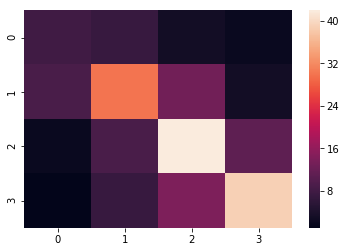

In [24]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [25]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [26]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [ ]:
krippendorffs_alpha(anno.annotations[::])

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [ ]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

In [ ]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

In [ ]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [ ]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [ ]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

Or averaged over the total:

In [ ]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

In [ ]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [ ]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

## <span style="color:red">*Excercise 2*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides on this week's Canvas page.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

For my practice content annotation survey, I picked 50 random sentences from my book corpus and had Turk workers perform a sentiment judgement (on a 5 point Likert scale.)

# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides two relevant models: ModelB and ModelBt. Model B with $\theta$s models the relationship between each coder and code. Model B is a Bayesian generalization of the Dawid & Skene model from the reading. The following image schematically describes these models. <img src="../data/pyanno/Bmodel.png">

The models should provide very similar results. To estimate the parameters for any models, we first need to create a new model. 

In [ ]:
# create a new instance of model B, with 4 label classes
model = ModelB.create_initial_state(4,8)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

Now we train the model on our data. Pyanno allows one to use either MAP (maximum a posteriori estimation) or MLE (maximum likelihood estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator-annotation pair. First we will train with MAP, and then you can optionally training with MLE.

In [ ]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [ ]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

Uncomment the cell below if you would rather train by MLE.

In [ ]:
#model = ModelB.create_initial_state(4,8)
#model.mle(anno.annotations)
#print(model.theta)
#print(model.log_likelihood(anno.annotations))

Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [ ]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

Let's turn the posterior of the first 100 samples into a heatmap and compare with the raw vote tallies.

In [ ]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

In [ ]:
makeQuestionComparison(model, anno)

This differs markedly from taking annotator scores at face value. As you can see (the model-based probabilities are on left; the raw votes on right), the models helps us break ties between coders and in some cases dramatically downgrades the estimates from particularly bad coders.

Let's try everything again with ModelBt, which constrains ModelB so that each coder has a single estimate over the accuracy of all of their codes.

In [ ]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

In [ ]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

In [ ]:
model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [ ]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

Let's visualize the posterior of the first 10 samples according to ModelBt.

In [ ]:
makeQuestionComparison(model, anno)

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. We may also use the posterior themselves rather than the most probably code outcome.

## Visualizing coder accuracy

Let's make a plot of the accuracy for each annotator inferred from ModelBt. This might be helpful if you wanted to ban a "troll" from your crowdsourcing enterprise. The coder a very low accuracy likelihood is an outlier and should be "dropped from the team."

In [ ]:
model = ModelBt.create_initial_state(4,8)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

In [ ]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Hotel Reviews

If we want to do a simpler analysis we can look at a different data set, here are some hotel reviews from [expedia](https://www.kaggle.com/c/expedia-hotel-recommendations)

In [ ]:
df_hotels = pandas.read_csv('../data/hot_Reviews.csv', index_col=0)
df_hotels[:5]

Here a rank of 0 is a missing value and to simplify things more we will convert from a 1-10 scale to a 1-5 scale, with 0 as missing

In [ ]:
df_hotels = df_hotels.apply(lambda x: x // 2) #integer divide by 2 rounds all values

And we can visualize all the reviews as a heatmap with the missing values greyed out

In [ ]:
fig, ax = plt.subplots(figsize = (20,20))
seaborn.heatmap(df_hotels, cmap='rainbow', ax = ax)
plt.show()

To give the dataframe to pyanno we need to convert to np array and change the nans to intergers, lets use -1

In [ ]:
hot_mat = np.array(df_hotels.fillna(-1).as_matrix())
anno_hot = AnnotationsContainer.from_array(hot_mat, missing_values=[-1])

In [ ]:
anno_hot.annotations

In [ ]:
anno_hot.labels

In [ ]:
anno_hot.missing_values

Look at coder agreement

In [ ]:
pyanno.measures.agreement.labels_frequency(anno_hot.annotations, 6)#6 possible catagories

In [ ]:
c = pyanno.measures.agreement.confusion_matrix(anno_hot.annotations[:,0], anno_hot.annotations[:,1], 6) #6 possible catagories
print(c)
ac = seaborn.heatmap(c)
plt.show()

Most agreement is on 2 i.e. an average hotel and there's little agreement as rating go higher, likely due to scarcity in the sample

In [ ]:
scotts_pi(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

In [ ]:
krippendorffs_alpha(anno_hot.annotations[::])

In [ ]:
cohens_kappa(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

In [ ]:
m = pairwise_matrix(cohens_kappa, anno_hot.annotations)
fig, ax = plt.subplots(figsize = (15, 15))
seaborn.heatmap(m, ax =ax)

And to look at what model Bt thinkgs the correct reviews are:

In [ ]:
model_hot = ModelBt.create_initial_state(6, 49)
model_hot.mle(anno_hot.annotations)
#print(model.theta)
print(model_hot.log_likelihood(anno_hot.annotations))

In [ ]:
makeQuestionComparison(model_hot, anno_hot)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MLE or MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?